In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits
#import multiprocessing as mp
#import copy
#import datetime

In [117]:
nrc_direct = pynrc.NIRCam(filter='F182M', fov_pix=512, oversample=4)
nrc_circ   = pynrc.NIRCam(filter='F182M', pupil='CIRCLYOT', fov_pix=512, oversample=4)
nrc_bar  = pynrc.NIRCam(filter='F182M', pupil='WEDGELYOT',fov_pix=512, oversample=4)

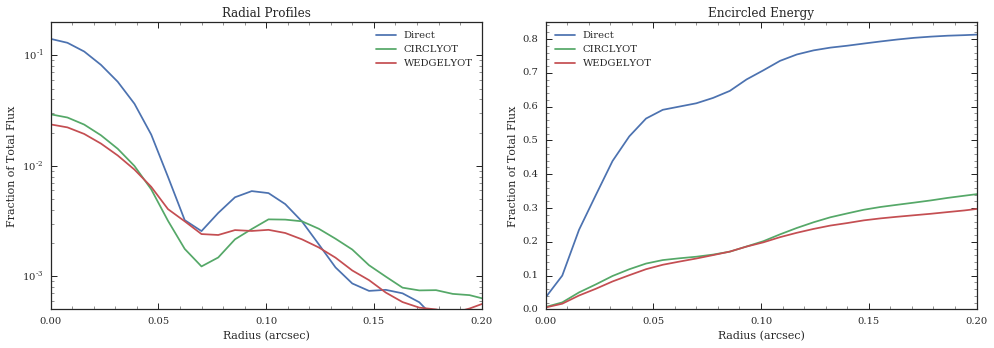

In [121]:
def to_hdu(nrc):
    psf, psf_over = nrc.gen_psf(return_oversample=True)
    psf /= psf.sum()
    psf_over /= psf_over.sum()
    
    hdu1 = fits.PrimaryHDU(psf)
    hdu1.header.append(('PIXELSCL', nrc.pix_scale))
    
    hdu2 = fits.PrimaryHDU(psf_over)
    pixscale_over = nrc.pix_scale/nrc.psf_info['oversample']
    hdu2.header.append(('PIXELSCL', pixscale_over))
    
    hdulist = fits.HDUList([hdu1])
    hdulist.append(hdu2)
    
    return hdulist
    

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

labels = ['Direct', 'CIRCLYOT', 'WEDGELYOT']
for i, nrc in enumerate([nrc_direct, nrc_circ, nrc_bar]):
    hdulist = to_hdu(nrc)
    rr, prof, EE_flux = nrc_utils.radial_profile(hdulist, 1, EE=True)
    ax1.semilogy(rr-rr.min(), prof*16, label=labels[i])
    ax2.plot(rr-rr.min(), EE_flux, label=labels[i])


ax1.set_ylim([5e-4,0.2])
ax2.set_ylim([0, 0.85])
ax1.set_title('Radial Profiles')
ax2.set_title('Encircled Energy')

for ax in (ax1,ax2):
    ax.minorticks_on()
    ax.set_xlim([0,0.2])
    ax.set_xlabel('Radius (arcsec)')
    ax.set_ylabel('Fraction of Total Flux')
    ax.legend(loc=0)

fig.tight_layout()

In [73]:
# K=6 Star
bp_k = S.ObsBandpass('k')
bp_k.name = 'K-Band'
sp = pynrc.stellar_spectrum('G2V', 6.0, 'vegamag', bp_k)
sp = pynrc.stellar_spectrum('G2V', 0.071, 'mJy', bp_k)

# Set up instrument with and without ND square
nrc_direct = pynrc.NIRCam(filter='F335M', ngroup=89)
nrc_lyot   = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ngroup=2)
nrc_coron  = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', mask='MASK335R', ngroup=2)
nrc_ND     = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ND_acq=True, ngroup=3, 
                          wind_mode='WINDOW', xpix=64, ypix=64)

In [76]:
nrc_direct.multiaccum_times
#print(nrc_direct.gen_psf(sp).max() / nrc_direct.gen_psf(sp).sum())
#print(nrc_lyot.gen_psf(sp).max() / nrc_lyot.gen_psf(sp).sum())
#print(0.1812/0.0361)

{u't_acq': 966.3093,
 u't_exp': 955.57253,
 u't_frame': 10.73677,
 u't_group': 10.73677,
 u't_int': 955.57253,
 u't_int_tot': 966.3093}

In [78]:
print(nrc_direct.sensitivity(nsig=10, sp=sp, units='mJy'))
#print(nrc_lyot.sat_limits(bp_lim=bp_k))
#print(nrc_ND.sat_limits(bp_lim=bp_k))

({u'units': 'mJy', u'sensitivity': 6.5080285198904444e-05, u'nsig': 10, u'Spectrum': 'G2V'}, {u'units': u'mJy/arcsec^2', u'sensitivity': 0.00065006623998981343, u'nsig': 10, u'Spectrum': 'G2V'})


In [58]:
print(nrc_direct.sat_limits(bp_lim=bp_k))
print(nrc_lyot.sat_limits(bp_lim=bp_k))
print(nrc_ND.sat_limits(bp_lim=bp_k))

{u'units': u'vegamag', u'bp_lim': 'K-Band', u'Spectrum': u'G2V', u'satmag': 13.91045658092871}
{u'units': u'vegamag', u'bp_lim': 'K-Band', u'Spectrum': u'G2V', u'satmag': 10.313397627492185}
{u'units': u'vegamag', u'bp_lim': 'K-Band', u'Spectrum': u'G2V', u'satmag': -1.930243041750428}


In [72]:
im = nrc_direct.gen_psf(sp=sp)
_im = nrc_direct.Detectors[0].pixel_noise(fsrc=im)
(im/_im).max()
#im.max()

33.442309503935505

In [60]:
print(nrc_direct.sensitivity(sp=sp, units='mJy'))
#print(nrc_lyot.sat_limits(bp_lim=bp_k))
#print(nrc_ND.sat_limits(bp_lim=bp_k))

({u'units': 'mJy', u'sensitivity': 0.0042863118509509426, u'nsig': 10, u'Spectrum': 'G2V'}, {u'units': u'mJy/arcsec^2', u'sensitivity': 0.042662188347321307, u'nsig': 10, u'Spectrum': 'G2V'})


In [14]:
obs_lyot = S.Observation(sp, nrc_lyot.bandpass, binset=nrc_lyot.bandpass.wave)
obs_ND = S.Observation(sp, nrc_ND.bandpass, binset=nrc_ND.bandpass.wave)

In [20]:
#print(obs_lyot.countrate(), obs_ND.countrate())
nrc_ND.ramp_optimize(sp, snr_goal=200)
#nrc_ND.sensitivity(nsig=200, sp=sp, units='vegamag')

Pattern,NGRP,NINT,t_int,t_exp,t_acq,SNR,Well,eff
unicode8,int64,int64,float64,float64,float64,float64,float64,float64
DEEP8,19,9,18.46,166.13,166.58,199.5,0.010,15.460
DEEP8,19,10,18.46,184.59,185.09,210.3,0.010,15.460
DEEP8,18,10,17.46,174.56,175.06,203.8,0.009,15.403
DEEP8,18,11,17.46,192.01,192.56,213.8,0.009,15.403
DEEP8,17,10,16.45,164.52,165.03,197.1,0.009,15.339
DEEP8,17,11,16.45,180.98,181.53,206.7,0.009,15.339
DEEP2,20,9,19.16,172.45,172.90,200.4,0.010,15.239
DEEP2,20,10,19.16,191.61,192.11,211.2,0.010,15.239
DEEP8,15,12,14.45,173.35,173.95,200.3,0.008,15.184


In [22]:
nrc_ND.update_detectors(read_mode='DEEP8', ngroup=25, nint=9)
nrc_ND.sensitivity(sp, forwardSNR=True)

({u'Spectrum': u'Flat spectrum in photlam',
  u'flux': 283927142869.46906,
  u'flux_units': u'nJy',
  u'snr': 5658.330296064165,
  u'type': u'Point Source'},
 {u'Spectrum': u'Flat spectrum in photlam',
  u'flux': 283927142869.46906,
  u'flux_units': u'nJy/arcsec^2',
  u'snr': 9840.3022969038484,
  u'type': u'Surface Brightness'})

In [ ]:
test_nd = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ND_acq=False, 
                       wind_mode='WINDOW', xpix=64, ypix=64, ngroup=5)
test_nd.multiaccum_times
test_nd.sensitivity(units='vegamag')

sp = pynrc.stellar_spectrum('flat', 6.0, 'vegamag', test_nd.bandpass)
tbl = test_nd.ramp_optimize(sp, snr_goal=100, verbose=True, nint_max=1)